In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Concatenate,UpSampling2D,Dropout,Input,Add,Conv2DTranspose
from tensorflow.keras.metrics import Precision,Recall
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as k
from tensorflow.keras.metrics import Accuracy,Precision , Recall
from sklearn.model_selection import train_test_split
import numpy as np 
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def fcn(input_size):
    input_scan = Input(input_size)
    conv1 = Conv2D(32,(3,3),padding="same",activation="relu")(input_scan)
    conv1 = Conv2D(32,(3,3),padding="same",activation="relu")(conv1)
    pool1 = MaxPooling2D((2,2),strides=2)(conv1)
    conv2 = Conv2D(64,(3,3),padding="same",activation="relu")(pool1)
    conv2 = Conv2D(64,(3,3),padding="same",activation="relu")(conv2)
    pool2 = MaxPooling2D((2,2),strides=2)(conv2)
    conv3 = Conv2D(128,(3,3),padding="same",activation="relu")(pool2)
    conv3 = Conv2D(128,(3,3),padding="same",activation="relu")(conv3)
    pool3 = MaxPooling2D((2,2),strides=2)(conv3)
    conv4 = Conv2D(256,(3,3),padding="same",activation="relu")(pool3)
    conv4 = Conv2D(256,(3,3),padding="same",activation="relu")(conv4)
    pool4 = MaxPooling2D((2,2),strides=2)(conv4)
    conv5 = Conv2D(512,(3,3),padding="same",activation="relu")(pool4)
    up1   = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv5)
    conv6 = Conv2D(64,(3,3),padding="same",activation="relu")(up1)
    merg1 = Add()([conv6,up1])
    up2   = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(merg1)
    conv7 = Conv2D(32,(3,3),padding="same",activation="relu")(up2)
    merg2 = Add()([conv7,up2])
    up3   = Conv2DTranspose(16,(2, 2), strides=(2, 2), padding='same')(merg2)
    conv8 = Conv2D(16,(3,3),padding="same",activation="relu")(up3)
    merg3 = Add()([conv8,up3])
    up4   = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same')(merg3)
    conv9 = Conv2D(8,(3,3),padding="same",activation="relu")(up4)
    merg4 = Add()([conv9,up4])
    out_layer = Conv2D(1,(1,1),padding="same",activation="sigmoid")(merg4)
    model = tf.keras.Model(input_scan,out_layer,name='deeplabv3')
    return model

In [3]:
fcn = fcn((512,512,1))

In [4]:
fcn.summary()

Model: "deeplabv3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 512, 512, 32  9248        ['conv2d[0][0]']                 
                                )                                                         

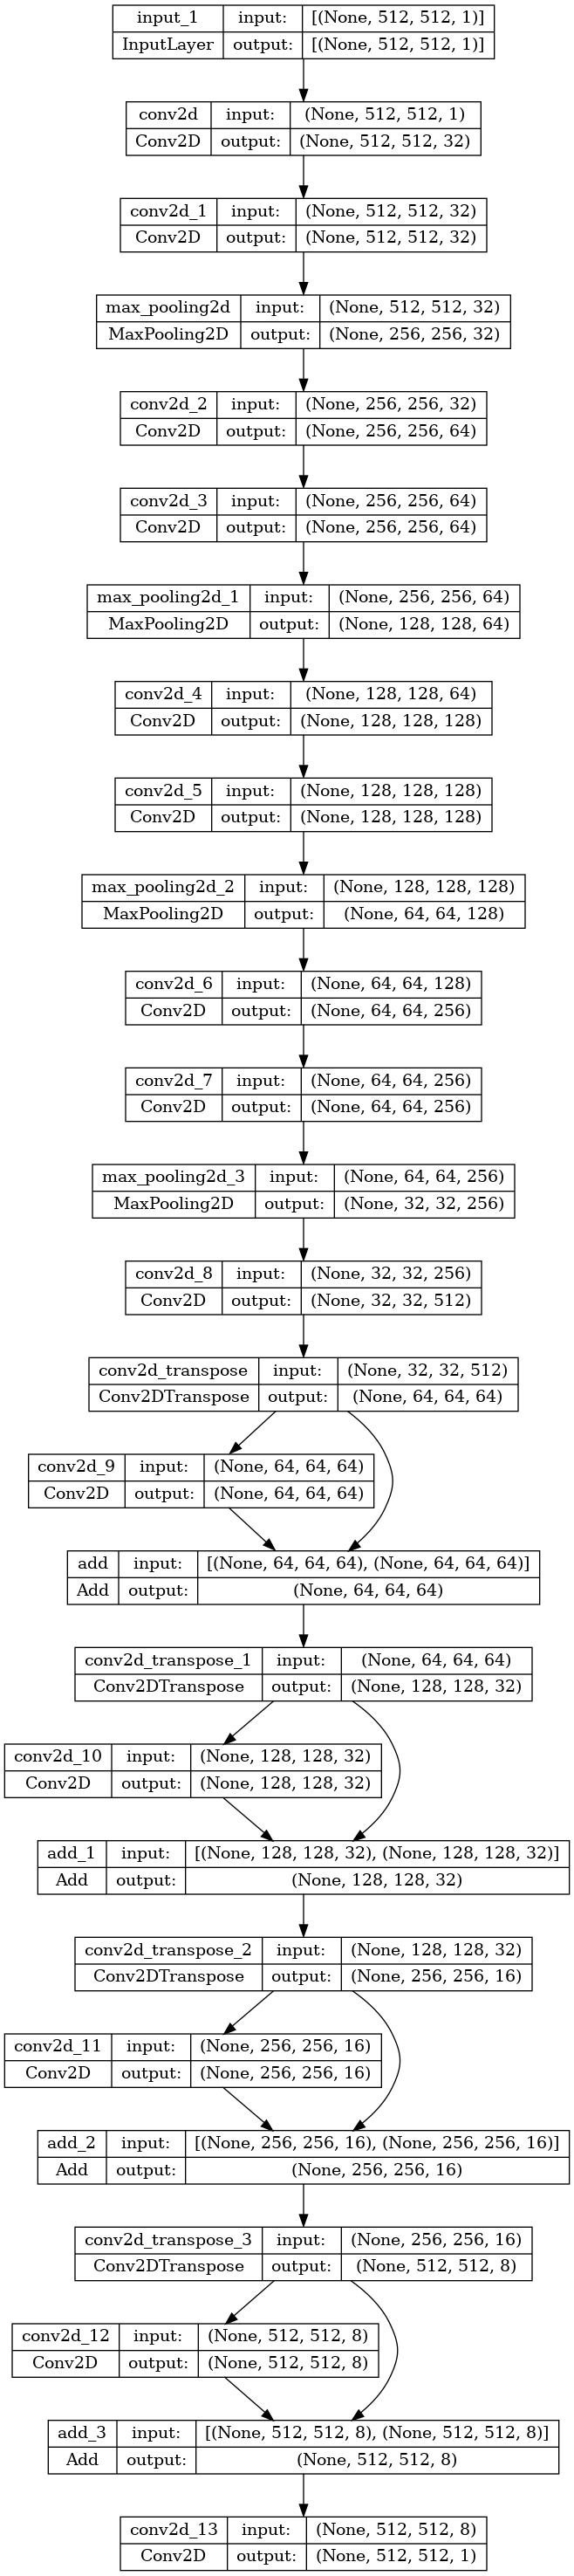

In [5]:
from tensorflow.keras.utils import plot_model
plot_model(fcn, show_shapes=True, rankdir='TB',
to_file='model_cifar10.png')

In [6]:
X1 = np.load("/kaggle/input/data12/X1.npy")
X0 = np.load("/kaggle/input/data12/X0.npy")
Y1 = np.load("/kaggle/input/data12/mask1.npy")
Y0 = np.load("/kaggle/input/data12/mask0.npy")

In [7]:
X = np.concatenate((X1,X0),axis=0)
Y = np.concatenate((Y1,Y0),axis=0)

In [8]:
X=X/255

In [9]:
Xtrain,Xtest,Ytrain,Ytest = train_test_split(X,Y,test_size =0.20,random_state=48)

In [10]:
from tensorflow.keras.layers import Flatten
def iou_coeff(y_true, y_pred):
    intersection = 0 
    y_true_f = Flatten()(y_true)
    y_pred_f = Flatten()(y_pred)
    intersection =  (2.*(y_true_f * y_pred_f) + tf.keras.backend.epsilon())
    union = (y_true_f + y_pred_f + tf.keras.backend.epsilon())
    return (intersection/union)

In [11]:
fcn.compile(optimizer = Adam(learning_rate=0.0001),loss = "binary_crossentropy",metrics=["accuracy",iou_coeff])

In [12]:
X1=0
X0=0
Y1 =0
Y0=0
X=0
Y=0

In [13]:
hist = fcn.fit(Xtrain,Ytrain,epochs=50,batch_size=32,validation_split=0.20)

Epoch 1/50
30/30 [==============================] - 36s 608ms/step - loss: 0.6225 - accuracy: 0.8051 - iou_coeff: 2.7087e-04 - val_loss: 0.3569 - val_accuracy: 0.8509 - val_iou_coeff: 6.3926e-04
Epoch 2/50
30/30 [==============================] - 14s 453ms/step - loss: 0.0884 - accuracy: 0.9770 - iou_coeff: 0.5066 - val_loss: 0.0265 - val_accuracy: 0.9995 - val_iou_coeff: 0.8302
Epoch 3/50
30/30 [==============================] - 13s 442ms/step - loss: 0.0150 - accuracy: 0.9996 - iou_coeff: 0.5657 - val_loss: 0.0106 - val_accuracy: 0.9995 - val_iou_coeff: 0.3784
Epoch 4/50
30/30 [==============================] - 13s 451ms/step - loss: 0.0077 - accuracy: 0.9996 - iou_coeff: 0.2685 - val_loss: 0.0067 - val_accuracy: 0.9995 - val_iou_coeff: 0.1536
Epoch 5/50
30/30 [==============================] - 14s 452ms/step - loss: 0.0056 - accuracy: 0.9996 - iou_coeff: 0.1442 - val_loss: 0.0056 - val_accuracy: 0.9995 - val_iou_coeff: 0.1681
Epoch 6/50
30/30 [==============================] - 13s 4

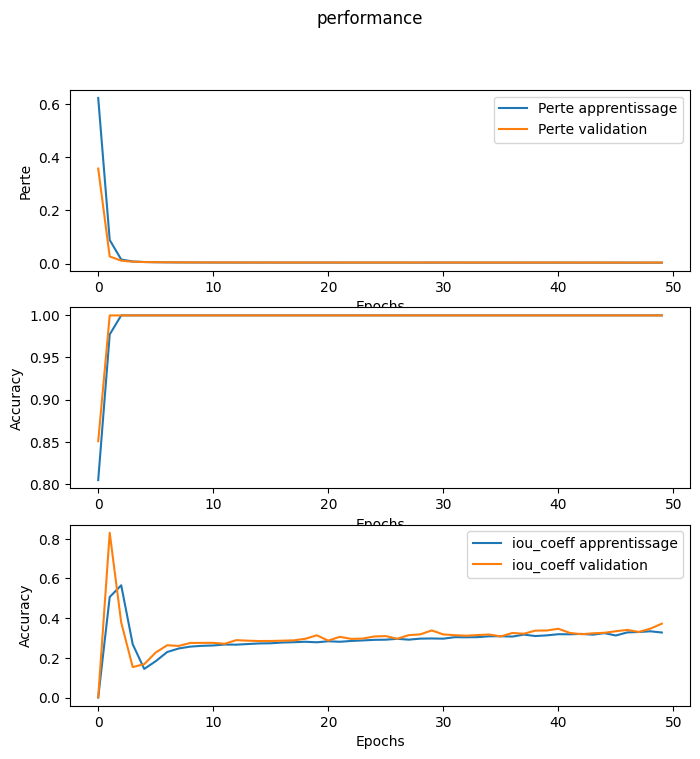

In [15]:
plt.figure(1, figsize=(8, 8))
plt.suptitle("performance") 
plt.subplot(3, 1, 1)
plt.plot(np.arange(0, 50), hist.history["loss"], label="Perte apprentissage")
plt.plot(np.arange(0, 50), hist.history["val_loss"], label="Perte validation")
plt.xlabel("Epochs")
plt.ylabel("Perte")
plt.legend() 
plt.subplot(3, 1, 2)
plt.plot(np.arange(0, 50), hist.history["accuracy"], label="Accuracy apprentissage")
plt.plot(np.arange(0, 50), hist.history["val_accuracy"], label="Accuracy validation") 
plt.xlabel("Epochs") 
plt.ylabel("Accuracy")
plt.subplot(3, 1, 3)
plt.plot(np.arange(0, 50), hist.history["iou_coeff"], label="iou_coeff apprentissage")
plt.plot(np.arange(0, 50), hist.history["val_iou_coeff"], label="iou_coeff validation") 
plt.xlabel("Epochs") 
plt.ylabel("Accuracy")
plt.legend()

plt.legend()


In [16]:
fcn.evaluate(Xtest,Ytest)

10/10 [==============================] - 2s 204ms/step - loss: 0.0037 - accuracy: 0.9995 - iou_coeff: 0.3693


[0.003670930163934827, 0.9995196461677551, 0.3693174719810486]

In [17]:


y_1 = fcn.predict(Xtest[3].reshape((1,512,512, 1)))

1/1 [==============================] - 1s 555ms/step


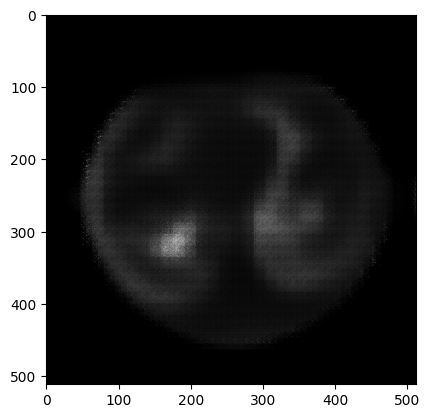

In [18]:
y_1 = y_1.reshape((512,512))
plt.imshow(y_1,cmap="gray")

In [19]:
y_1.max()

0.0042130006

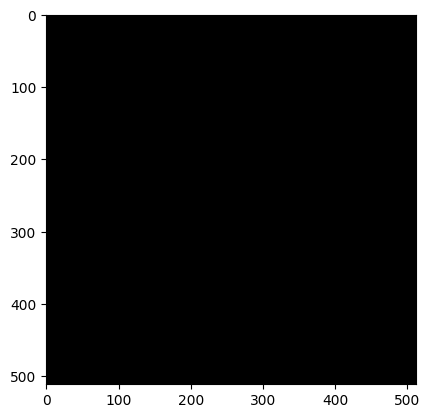

In [20]:
y_1 = np.where(y_1>0.5,1,0)
plt.imshow(y_1,cmap="gray")

In [21]:

norm_img = Xtest[10].reshape((512,512))
img = norm_img * 255

/tmp/ipykernel_31/3553443511.py:6: UserWarning: No contour levels were found within the data range.
  ax2.contour(y_1.reshape((512,512)), levels=[0.4], colors='r', linewidths=2)


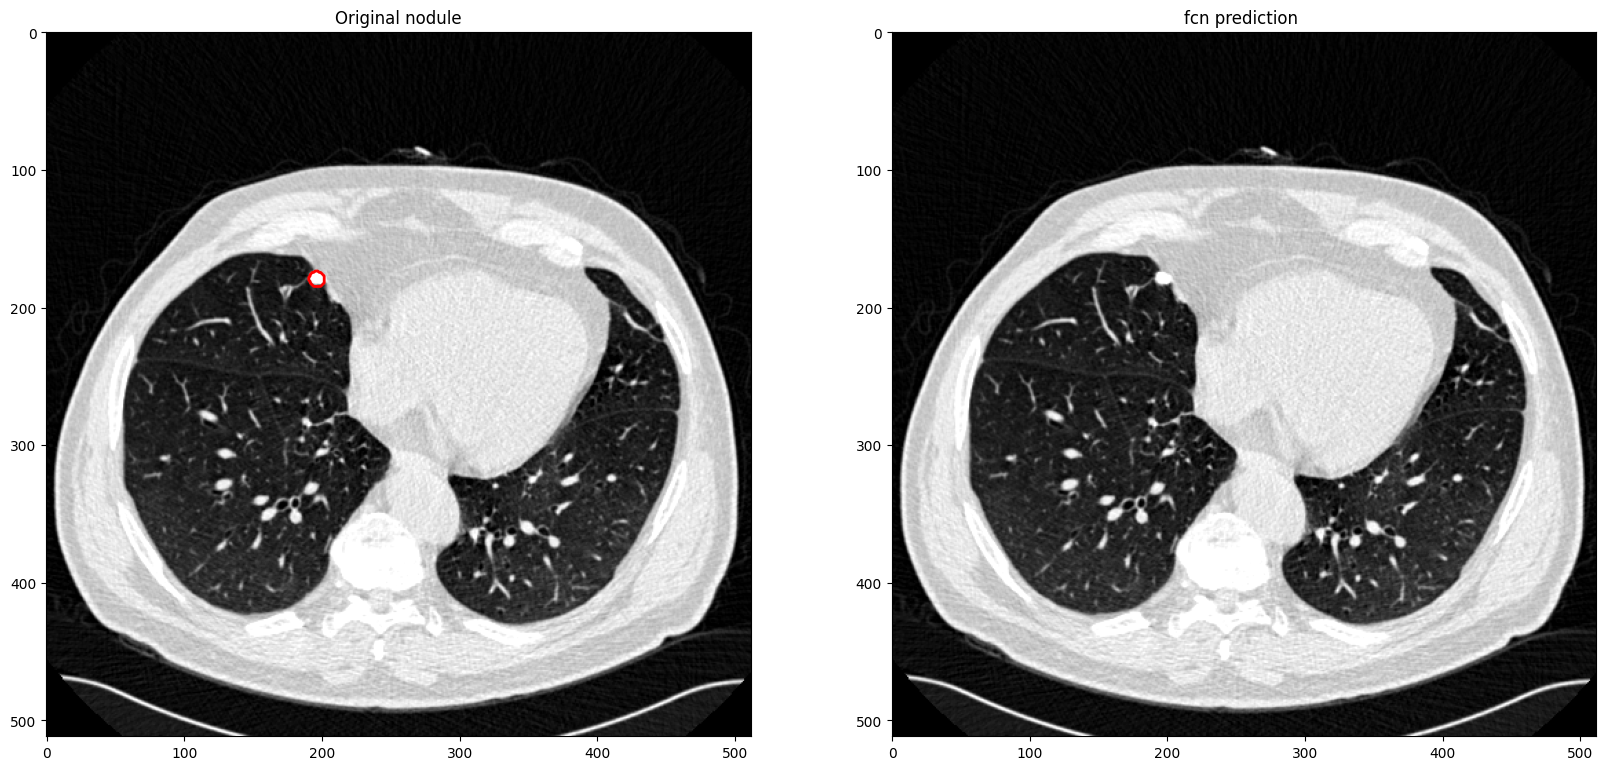

In [22]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 20))
ax1.imshow(img,cmap="gray" )
ax1.set_title('Original nodule')
ax2.imshow(img,cmap='gray')
ax2.set_title('fcn prediction ')
ax2.contour(y_1.reshape((512,512)), levels=[0.4], colors='r', linewidths=2)
ax1.contour(Ytest[10].reshape((512,512)), levels=[0.4], colors='r', linewidths=2)
plt.show()